<a id="section_ID_0"></a>
# Graph-Theoretical Prediction of Biological Modules in a Bacteriophage - PDB ID 6QYD

<b>Authors:</b><br>
Florian J. Gisdon (mail: florian.gisdon@bioinformatik.uni-frankfurt.de)<br>
Kai Prüfer

This Jupyter Notebook is part of the supporting information of  <i>Gisdon et al. - Graph-theoretical prediction of biological modules in quaternary structures of large protein complexes.</i>
The quaternary structure of the protein complex is modeled as undirected, labeled graph with the vertices representing protein chains and the edges spatial chain-chain contacts. Biological modules are predicted based on the protein graph by partitioning with the Leiden algorithm.

## Table of Contents:

1. **[Requirements](#section_ID_1)**

1. **[Imports](#section_ID_2)**

1. **[Prepare Data and Run PTGLgraphComputation (Optional)](#section_ID_3)**
    <br>3.1 [Check for Installed Software](#section_ID_3.1)
    <br>3.2 [Prepare Variables, Files, and Folders](#section_ID_3.2)
    <br>3.3 [Define Options for the PTGL](#section_ID_3.3)
    <br>3.4 [Compute the Complex Graph with the PTGL](#section_ID_3.4)

1. **[Module Prediction (iGraph) and Analysis](#section_ID_4)**
    <br>4.1 [Import the Complex Graph](#section_ID_4.1)
    <br>4.2 [Perform Community Detection by Optimization of Q-Modularity](#section_ID_4.2)
        <br>4.2.1 [Set Parameters](#section_ID_4.2.1)
        <br>4.2.2 [Perform the Community Detection](#section_ID_4.2.2)
    <br>4.3 [Store/Load Partitions for Later Use](#section_ID_4.3)

1. **[Visualization](#section_ID_5)**
    <br>5.1 [Edge Weight Type](#section_ID_5.1)
        <br>5.1.1 [Choose the Weight Type for the Analysis](#section_ID_5.1.1)
        <br>5.1.2 [Apply a Heatmap Coloring to the Edges According to the Edge Weight](#section_ID_5.1.2)
    <br>5.2 [PyMOL Visualization](#section_ID_5.2)
    <br>5.3 [Prepare Layout According to the Pseudoatom Coordinates](#section_ID_5.3)
    <br>5.4 [Prepare a General Representation Style for the Graphs](#section_ID_5.4)
        <br>5.4.1 [Optional Modification of Vertex Positions](#section_ID_5.4.1)
        <br>5.4.2 [Prepare a General Graph Layout Style](#section_ID_5.4.2)
    <br>5.5 [Graph Visualization with Focus on the Network](#section_ID_5.5)
        <br>5.5.1 [Layout Style with Focus on Network](#section_ID_5.5.1)
        <br>5.5.2 [Plotting the Graph](#section_ID_5.5.2)
    <br>5.6 [Graph Visualization with Focus on the Computed Partitions](#section_ID_5.6)
        <br>5.6.1 [Layout Style with Labels and Partitions](#section_ID_5.6.1)
        <br>5.6.2 [Plotting the Graph](#section_ID_5.6.2)

<a id="section_ID_1"></a>
## 1. Requirements

- igraph
- pycairo
- numpy
- matplotlib
- shutil
- pickle
- pandas
- provided scripts (generalFunctions, pymolRepresentationClustering)

#### Optional

- Protein Topology Graph Library (PTGL)  
    &#10140; PTGLtools - <a href="https://github.com/MolbiFFM/PTGLtools"> GitHub repository</a>
- DSSP  
    &#10140; e.g. DSSP (PDB-REDO) - <a href="https://github.com/PDB-REDO/dssp"> Github repository</a>
- PyMOL

<a id="section_ID_2"></a>
## 2. Imports

In [1]:
import os
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import warnings

import igraph as ig

# Replace with the absolute path to the directory of the provided scripts ('../' in the example).
script_path: str = '../'
sys.path.append(script_path)

from pymolRepresentationClustering import prepareClusteringRepresentationPyMOL
from generalFunctions import download_pdb, createLayout, modifyLayoutPosition


# The computation time of the Jupyter Notebook and each of its cells was captured via the
# python time module and tested on two different machines.

# Tested on a Laptop with the following specs:
# Processor: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz   2.59 GHz
# Physical Cores: 2
# Logical Cores: 4
# RAM: 16.0 GB
# Cell took 2.0021808147s to execute.

# Tested on a PC with the following specs:
# Processor: Intel(R) Xeon(R) CPU E3-1246 v3 @ 3.50GHz
# Physical Cores: 4
# Logical Cores: 8
# RAM: 16.0 GB
# Cell took 0.6388933659s to execute.

<a id="section_ID_3"></a>
## 3. Prepare Data and Run PTGLgraphComputation (Optional)

<div class="alert alert-block alert-info"><b>This example notebook is provided with the required files for all steps and will also run if DSSP, PTGL, or PyMOL is not available. PyMOL is not required for the calculations but for displaying the modules in the protein structure.</b><br>Set variables in section 3.1 to <i>False</i> to run the example without installing PTGL, DSSP, and PyMOL. If the software is available, set the respective variables to <i>True</i> and provide the paths.</div>

<a id="section_ID_3.1"></a>
### 3.1 Check for Installed Software

The PTGL computation for the bacteriophage-6qyd took 1:28:24 h:m:s.ms on a PC with the following specs:  
Processor: Intel(R) Xeon(R) CPU E3-1246 v3 @ 3.50GHz  
CPU's: 8  
Core's per socket: 4  
RAM: 16 GB

In [2]:
dssp_software: bool = False
# Applied tool: https://github.com/PDB-REDO/dssp, version 4.4.
# Replace >...< with the absolute path to the dssp executable.
dssp: str = '>/absolute/path/to/mkdssp<'

ptgl_software: bool = False
# Replace >...< with the absolute path to the PTGL executable
ptgl: str = 'java -jar >/absolute/path/to/PTGLgraphComputation.jar<'

# For visualization of the results from the paper, set to True.
pymol_software: bool = False
# Replace >...< with the absolute path to the PyMOL executable.
pymol: str = '>/absolute/path/to/pymol<'


# DSSP, PTGL, PyMOL = False: Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0001542568s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0001156330s to execute with the pc specs.

<a id="section_ID_3.2"></a>
### 3.2 Prepare Variables, Files, and Folders

In [3]:
pdb_id: str = '6qyd'

# PDB/mmCIF (should be in the folder where PTGL is started).
structure: str = f'{pdb_id}.cif'

# If required, the mmCIF file is downloaded. For large files it may take some time.
if not os.path.exists(structure):
    print(f"{structure} does not exist in the current working directory.\
          \nDownloading...")
    download_pdb(pdb_id)
    print("Download complete.")

# Set output directory for the results (many files) of the PTGL run.
output_directory: str = 'ptgl_output'
try:
    os.makedirs(output_directory, exist_ok=True)
except OSError as error:
    print("Directory can not be created.")

# Adding the DSSP annotation.
if dssp_software:
    os.system(f'{dssp} {structure} annotated_{structure}')


# DSSP, PTGL, PyMOL = False: Cell took 0.0009984970s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0:14:25.78 h:m:s.ms to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 11.5333104134s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0:09:46.03 h:m:s.ms to execute with the pc specs.

<a id="section_ID_3.3"></a>
### 3.3 Define Options for PTGL

In [4]:
options: str = f'-d annotated_{structure} \
                 --complex-graphs \
                 --outputdir {output_directory} \
                 --dont-write-images \
                 --cg-threshold 1'

ptgl_output_file: str = 'PTGLrun.log'


# DSSP, PTGL, PyMOL = False: Cell took 0.0091304779s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0002570152s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0000772476s to execute with the pc specs.

<a id="section_ID_3.4"></a>
### 3.4  Compute the Complex Graph with the PTGL

If an annotated mmCIF is provided with option `'-d'` then the input structure (second positional argument, i.e. {pdb_id}) will be ignored but has to be given (can be given as `'None'`).

In [5]:
if ptgl_software:
    os.system(f'{ptgl} {pdb_id} {options} | tee {ptgl_output_file}')


# DSSP, PTGL, PyMOL = False: Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 1:57:41.38 h:m:s.ms to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0000836849s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 1:28:24.13 h:m:s.ms to execute with the pc specs.

<a id="section_ID_4"></a>
## 4. Module Prediction (iGraph) and Analysis

<a id="section_ID_4.1"></a>
### 4.1 Import the Complex Graph

In [6]:
# Ignores the possible runtime warning resulting from igraph not being
# able to process one of the custom graph attributes given by PTGL.
warnings.filterwarnings('ignore', category=RuntimeWarning)

graph_file: str = f'{output_directory}/6qyd_complex_chains_albelig_CG.gml'
G = ig.Graph.Read_GML(graph_file)
# Prints number of graph vertices and edges, as well as the attributes.
ig.summary(G)


# DSSP, PTGL, PyMOL = False: Cell took 0.1088519096s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.1486747265s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0471205711s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0438890457s to execute with the pc specs.

IGRAPH U--- 400 1688 -- 
+ attr: creator (g), factorLucidmultiplicativelengthnormalization (g), ignoreLigands (g), minContactsForEdge (g), version (g), chainGyradius (v), chainLength (v), chainType (v), id (v), label (v), molName (v), absoluteWeight (e), additiveGyrationIndividualNormalization (e), additiveGyrationNormalization (e), additiveIndividualNormalization (e), additiveLengthNormalization (e), label (e), lucidMultiplicativeLengthNormalization (e), multiplicativeIndividualNormalization (e), multiplicativeLengthNormalization (e), numCoilCoilContacts (e), numHelixCoilContacts (e), numHelixHelixContacts (e), numHelixStrandContacts (e), numStrandCoilContacts (e), numStrandStrandContacts (e)


<a id="section_ID_4.2"></a>
### 4.2 Perform Community Detection by Optimization of Q-Modularity

<a id="section_ID_4.2.1"></a>
#### 4.2.1 Set Parameters

In [7]:
# We perform independent computations, since the order in which
# the vertices in the implementation are processed is random, 
# which could lead to variations in the results. We choose the
# partition with the highest Q-modularity. Based on initial
# numerical tests, we performed 2000 computations.
number_of_runs: int = 2000

# List of various weight types, which are written out by the PTGL.
# The Code supports the option to add additional weight types, though
# except for 'absoluteWeight', other types are not yet evaluted.
# 'absoluteWeight' describes the absolute number of contacts.
weight_types: list = ['absoluteWeight']

# Set the resolution parameter for the generalized Q-modularity.
resolution: float = 1.0
# Dictionary, which will store all the partitions with the highest
# Q-modularity for each weight type.
partitions: dict = {}

folder_path: str = "./modularization_results"
# Checking whether folder exists or not.
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    os.makedirs(folder_path)
else:
    os.makedirs(folder_path)


# DSSP, PTGL, PyMOL = False: Cell took 0.0144183636s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0684514046s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0012211800s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0027267933s to execute with the pc specs.

<a id="section_ID_4.2.2"></a>
#### 4.2.2 Perform the Clustering Using Different Edge Weight Types

In [8]:
for weight_type in weight_types:
    print(f'Edge weight type: {weight_type}')
    calc_modularity: list = []
    best_partition = None

    try:
        for run in range(number_of_runs):
            # Calculate the partitioning.
            part_Leiden_calc = G.community_leiden(objective_function='modularity',
                                                  weights=weight_type,
                                                  resolution_parameter=resolution,
                                                  n_iterations=-1)

            if len(calc_modularity) == 0:
                best_partition = part_Leiden_calc
            elif part_Leiden_calc.modularity > max(calc_modularity):
                best_partition = part_Leiden_calc
            calc_modularity.append(part_Leiden_calc.modularity)

        # Print the SVG image for the best Q-modularity to file.
        ig.plot(best_partition, f"{folder_path}/best_modularity_{weight_type}.svg")
        # Print out the PML-file for the representation with PyMOL.
        pml_file = prepareClusteringRepresentationPyMOL(
                                            structure,
                                            graph_file,
                                            best_partition,
                                            [int(vertex['id']) for vertex in G.vs()],
                                            [list(ig.color_name_to_rgb(color))
                                             for color in ig.drawing.colors\
                                            .ClusterColoringPalette(len(best_partition))])

        with open(f"{folder_path}/show_best_modules_{weight_type}.pml", "w") as f:
            f.write(pml_file)

        # Save the best partitions to a dictionary.
        partitions[weight_type] = best_partition

        # Print out some results.
        print(f'\nHighest calculated modularity: {max(calc_modularity)}')
        for number, community in enumerate(best_partition):
            print(f'Community {number}')
            print(f'\tNumber of nodes: {G.vs.select(community).subgraph().vcount()}')
            print(f'\tNumber of edges: {G.vs.select(community).subgraph().ecount()}')
        print('\n')
    except Exception as e:
        print('Weight type not available.')
        print(e)


# DSSP, PTGL, PyMOL = False: Cell took 7.4596073627s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 7.7106611729s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 1.9439759254s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 1.9512884617s to execute with the pc specs.

Edge weight type: absoluteWeight


/tmp/ipykernel_30174/3468140103.py:9: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  part_Leiden_calc = G.community_leiden(objective_function='modularity',



Highest calculated modularity: 0.7696499896110667
Community 0
	Number of nodes: 38
	Number of edges: 113
Community 1
	Number of nodes: 38
	Number of edges: 112
Community 2
	Number of nodes: 32
	Number of edges: 84
Community 3
	Number of nodes: 38
	Number of edges: 114
Community 4
	Number of nodes: 38
	Number of edges: 114
Community 5
	Number of nodes: 38
	Number of edges: 114
Community 6
	Number of nodes: 32
	Number of edges: 87
Community 7
	Number of nodes: 32
	Number of edges: 87
Community 8
	Number of nodes: 38
	Number of edges: 114
Community 9
	Number of nodes: 38
	Number of edges: 114
Community 10
	Number of nodes: 32
	Number of edges: 103
Community 11
	Number of nodes: 3
	Number of edges: 3
Community 12
	Number of nodes: 3
	Number of edges: 3




<a id="section_ID_4.3"></a>
### 4.3 Store/Load Partitions for Later Use

Once the partitions are obtained, they can be stored as a .pkl file, since recalculated partitions might vary slightly compared to previous results. In this example the provided partitions are loaded and the corresponding files are written.

In [9]:
dictionary_file: str = "calculatedPartitions.pkl"

store_calculated_partitions: bool = False
load_existing_partitions: bool = True

if store_calculated_partitions:
    # Save dictionary to a .pkl file.
    with open(dictionary_file, 'wb') as fp:
        pickle.dump(partitions, fp)

if load_existing_partitions:
    # Load the dictionary from a .pkl file.
    with open(dictionary_file, 'rb') as fp:
        partitions = pickle.load(fp)
    
    # Write the image files and PyMOL scripts according to the
    # currently loaded partitions.
    for weight_type in weight_types:    
        # Print the SVG image for the best Q-modularity to file.
        ig.plot(partitions[weight_type], f"{folder_path}/best_modularity_{weight_type}.svg")
        # Print out the PML-file for the representation with PyMOL.
        pml_file = prepareClusteringRepresentationPyMOL(
                                            structure,
                                            graph_file,
                                            partitions[weight_type],
                                            [int(vertex['id']) for vertex in G.vs()],
                                            [list(ig.color_name_to_rgb(color))
                                             for color in ig.drawing.colors\
                                            .ClusterColoringPalette(len(partitions[weight_type]))])
        with open(f"{folder_path}/show_best_modules_{weight_type}.pml", "w") as f:
            f.write(pml_file)


# DSSP, PTGL, PyMOL = False: Cell took 2.0820985794s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 2.0848526955s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.4689257145s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.4516372681s to execute with the pc specs.

<a id="section_ID_5"></a>
## 5. Visualization

<a id="section_ID_5.1"></a>
### 5.1 Edge Weight Type

<a id="section_ID_5.1.1"></a>
#### 5.1.1 Choose the Weight Type for the Analysis

In [10]:
weight_type: str = 'absoluteWeight'
maximum_weight: int = max(G.es[weight_type])


# DSSP, PTGL, PyMOL = False: Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0001170635s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0001096725s to execute with the pc specs.

<a id="section_ID_5.1.2"></a>
#### 5.1.2 Prepare a Heatmap Coloring for the Edges According to the Edge Weight

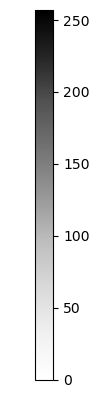

In [11]:
colormap: str = "Greys"

fig, ax = plt.subplots(1, 1)
fraction: int = 1
norm = mpl.colors.Normalize(vmin=0, vmax=maximum_weight)
cbar = ax.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap),
                          ax=ax,
                          fraction=fraction)

ax.axis('off')
# Save the color bar for later use in figures.
plt.savefig('colorbar.svg', bbox_inches='tight')


# DSSP, PTGL, PyMOL = False: Cell took 0.4779660702s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.4587988853s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.1360046864s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.1323473454s to execute with the pc specs.

# All cells so far (until the PyMOL startup request next cell) have taken:
# DSSP, PTGL, PyMOL = False: 26.3126745224s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  02:12:22.75 h:m:s.ms to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: 14.8503742218s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  01:28:13.61 h:m:s.ms to execute with the pc specs.

<a id="section_ID_5.2"></a>
### 5.2 PyMOL Visualization

<div class="alert alert-block alert-info"> Use PyMOL to visualize the protein chains. If PyMOL is not available, the visualization with the generated PML-scripts will not work and you can skip 5.2 and go on with the next steps.</div>

First, open PyMOL and load a representation script.

In [12]:
if pymol_software:
    # Use PyMOL.
    os.system(f'{pymol} {folder_path}/show_best_modules_{weight_type}.pml')


# DSSP, PTGL, PyMOL = False: Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0:56:62147 h:m:s.ms to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0000603199s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0:37:20.38 h:m:s.ms to execute with the pc specs.

Rotate the protein as desired in PyMOL and obtain the orientation by executing `get_view` from the PyMOL command line.  
To set the orientation as shown in the paper, insert the below code block into the PyMOL command line:
***
`set_view (\`  
     `  0.846083760,   -0.013588826,    0.532877386,\`  
     `  0.532879949,   -0.003809187,   -0.846183240,\`  
     `  0.013528440,    0.999899209,    0.004018756,\`  
     `  0.000000000,    0.000000000, -708.731262207,\`  
   `252.326522827,  202.360107422,  274.605560303,\`  
   `558.769104004,  858.693420410,  -20.000000000 )`
***

You can now write out the coordinates of the pseudoatoms to obtain the positions for the vertices in the graph representation. For that, insert the following code into the PyMOL shell as shown in below screenshots.

***
`xyz = cmd.get_coords("pseudoatoms", 1)`  
`python`  
`import numpy as np`  
`with open('pseudoatomCoords.npy', 'wb') as f: np.save(f, xyz)`  
`python end`

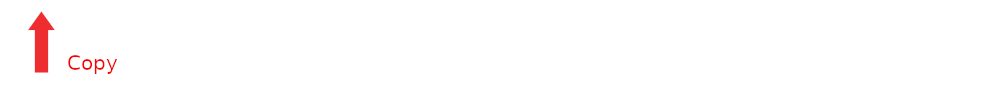

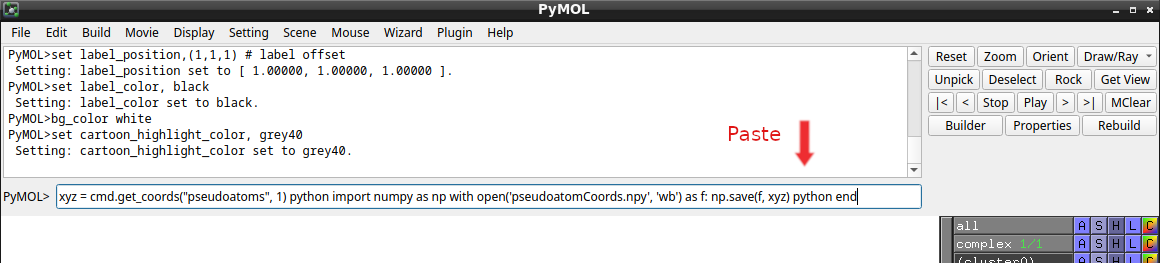

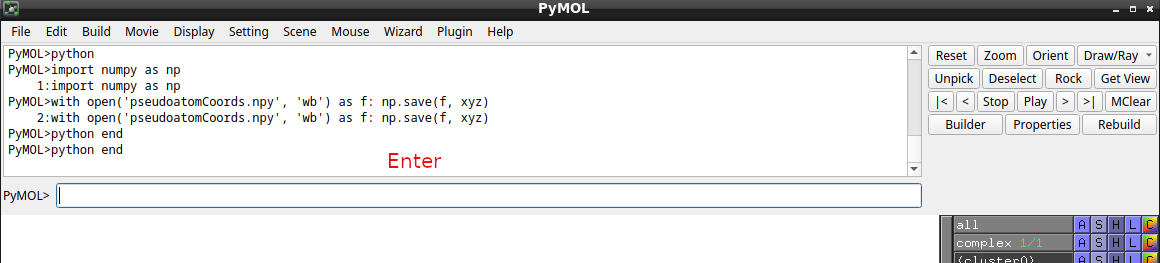

<div class="alert alert-block alert-info"> Note, that in order for the following cells (5.3 and further) to be executed, the cell running PyMOL first has to finish executing, i.e. quit PyMOL.</div>

<a id="section_ID_5.3"></a>
### 5.3 Prepare Layout According to the Pseudoatom Coordinates

The pseudoatom coordinates provide the geometric centers for each protein chain in the complex. The vertices in the graph figures are placed on the 2D projection of the pseudoatom coordinates along the z axis onto the xy plane. If the alpha values for the edge colors are used, the edges will be drawn accordingly, representing the depth in the plot view. For the vertices the alpha value is used in the respective colors and this might interfere with the alpha values for the depth view - change manually to not use the alpha values.

In [13]:
alpha = True

# Load the coordinates from file and create a numpy array.
coord_orig = np.load('pseudoatomCoords.npy')

# Use the provided set_view string to replicate the view from the results of the paper.
# It can be replaced with a different view from PyMOL, by replacing the string with the
# output of the 'get_view' statement as shown above.
set_view: str = 'set_view (\
    -0.906641483,    0.157472476,   -0.391399741,\
    -0.415019095,   -0.499721050,    0.760285437,\
    -0.075866848,    0.851746559,    0.518426120,\
     0.001238108,   -0.002868101, -2788.952636719,\
   354.281250000,  360.774200439,  403.292633057,\
  2283.456298828, 3294.590087891,  -20.000000000 )'

if alpha:
    new_layout, alpha_values = createLayout(set_view, coord_orig, alpha=True)
else:
    new_layout = createLayout(set_view, coord_orig, alpha=False)


# DSSP, PTGL, PyMOL = False: Cell took 0.0363738537s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0679175854s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0057380199s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0068690777s to execute with the pc specs.

<a id="section_ID_5.4"></a>
### 5.4 Prepare a General Representation Style for the Graphs

<a id="section_ID_5.4.1"></a>
#### 5.4.1 Optional Modification of Vertex Positions

Vertex positions might overlap in the adjusted view. Slight modifications for a better representation can be applied. For easier insight how to modify vertex positions, a dictionary is created which stores the coordinates and the respective chain names.

In [14]:
vertex_positions: dict = {}
for number, name in enumerate(G.vs['label']):
    vertex_positions[name] = new_layout[number]
print(vertex_positions)

# If necessary (e.g. because of overlapping vertices) modify the positions of the vertices.
# Example: 
# new_layout: list = modifyLayoutPosition('1A', new_layout, G, [-401.499, 490.02])


# DSSP, PTGL, PyMOL = False: Cell took 0.0019960403s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0088536739s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0005390644s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0006549358s to execute with the pc specs.

{'1A': [-409.499, 496.02], '1B': [-378.775, 474.751], '1C': [-365.78, 476.37], '1D': [-384.119, 502.411], '1E': [-414.846, 524.737], '1F': [-420.209, 520.764], '2A': [-359.778, 383.622], '2B': [-340.78, 369.267], '2C': [-332.533, 397.493], '2D': [-346.468, 430.068], '2E': [-363.39, 421.888], '3A': [-330.548, 382.045], '3B': [-335.679, 373.599], '3C': [-346.221, 402.725], '3D': [-351.539, 440.385], '3E': [-347.365, 448.897], '3F': [-336.174, 418.958], '4A': [-354.615, 307.04], '4B': [-363.172, 271.294], '4C': [-352.369, 260.435], '4D': [-338.999, 287.417], '4E': [-332.63, 324.969], '4F': [-337.712, 332.916], '5A': [-353.599, 293.168], '5B': [-355.492, 329.885], '5C': [-343.727, 338.592], '5D': [-336.298, 309.597], '5E': [-336.872, 271.523], '5F': [-342.554, 264.567], '6A': [-375.336, 152.689], '6B': [-358.096, 179.88], '6C': [-345.877, 215.041], '6D': [-350.141, 224.381], '6E': [-366.601, 197.85], '6F': [-378.621, 161.848], '7A': [-369.032, 170.8], '7B': [-383.34, 181.991], '7C': [-372.

<a id="section_ID_5.4.2"></a>
#### 5.4.2 Prepare a General Graph Layout Style

The edge labels for the graphs below are switched off by default for better clarity.

In [15]:
defined_width: list = [x/10 for x in G.es[weight_type]]
labeled_vertices: list = [name for name in G.vs['label']]

visual_style: dict = {
    'layout': new_layout,
    'bbox': (2400, 2800),
    'margin': 30,
    'edge_width': defined_width,
    'edge_label': None,  # To switch off labeling of the edges.
    'vertex_shape': 'circle',
    'vertex_label': labeled_vertices,
    'vertex_label_color': 'black',
    'vertex_label_size': 22
}


# DSSP, PTGL, PyMOL = False: Cell took 0.0000000000s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0020716190s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0003137589s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0003991127s to execute with the pc specs.

<a id="section_ID_5.5"></a>
### 5.5 Graph Visualization with Focus on the Network

<a id="section_ID_5.5.1"></a>
#### 5.5.1 Layout Style with Focus on Network

In the cell below the edge weight colors and the alpha values are applied.
The visual style for this graph is created with a focus on the network and its edges, meaning no colored clusters.

The alpha value for the network-focused style is recommended to be set to False to see the real colors according to the edge weights. However, the large complex graph of the bacteriophage structure becomes less clear without the alpha values.

In [16]:
alpha: bool = True
cmap = plt.get_cmap(colormap)

# General Network Layout:
visual_style_network: dict = visual_style.copy()
visual_style_network["vertex_size"]: int = 14
visual_style_network["vertex_label"]: list = None
visual_style_network["vertex_color"]: list = [ig.color_name_to_rgba('gray95')
                                              for vertex in G.vs()]
visual_style_network["vertex_frame_width"]: int = 8
# First create the list and if required apply the modification for the alpha values.
visual_style_network["vertex_frame_color"]: list = [ig.color_name_to_rgba('darkgreen')
                                                    for vertex in G.vs()]

# With alpha value.
if alpha:
    visual_style_network["edge_color"]: list = \
                            [cmap(edge[weight_type]/maximum_weight)[:-1]
                             + ((alpha_values[edge.source] + alpha_values[edge.target])/2,)
                             for edge in G.es()]
    visual_style_network["vertex_frame_color"]: list = \
                            [visual_style_network["vertex_frame_color"][number][:-1]
                            + (alpha_values[int(vertex['id'])],)
                            for number, vertex in enumerate(G.vs())]
    visual_style_network["vertex_color"]: list = \
                            [visual_style_network["vertex_color"][number][:-1]
                            + (alpha_values[int(vertex['id'])],)
                            for number, vertex in enumerate(G.vs())]
# Without alpha value.
else:  
    visual_style_network["edge_color"] = \
                            [cmap(weight/maximum_weight)
                             for weight in G.es[weight_type]]


# DSSP, PTGL, PyMOL = False: Cell took 0.2181398869s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.1726241112s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0989019871s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.1198923588s to execute with the pc specs.

<a id="section_ID_5.5.2"></a>
#### 5.5.2 Plotting the Graph

The below graph is shown in a large size for better visibility. To have a look use the scrollbar at the bottom of the cell, or alternatively, go directly to the automatically saved .svg graph file.

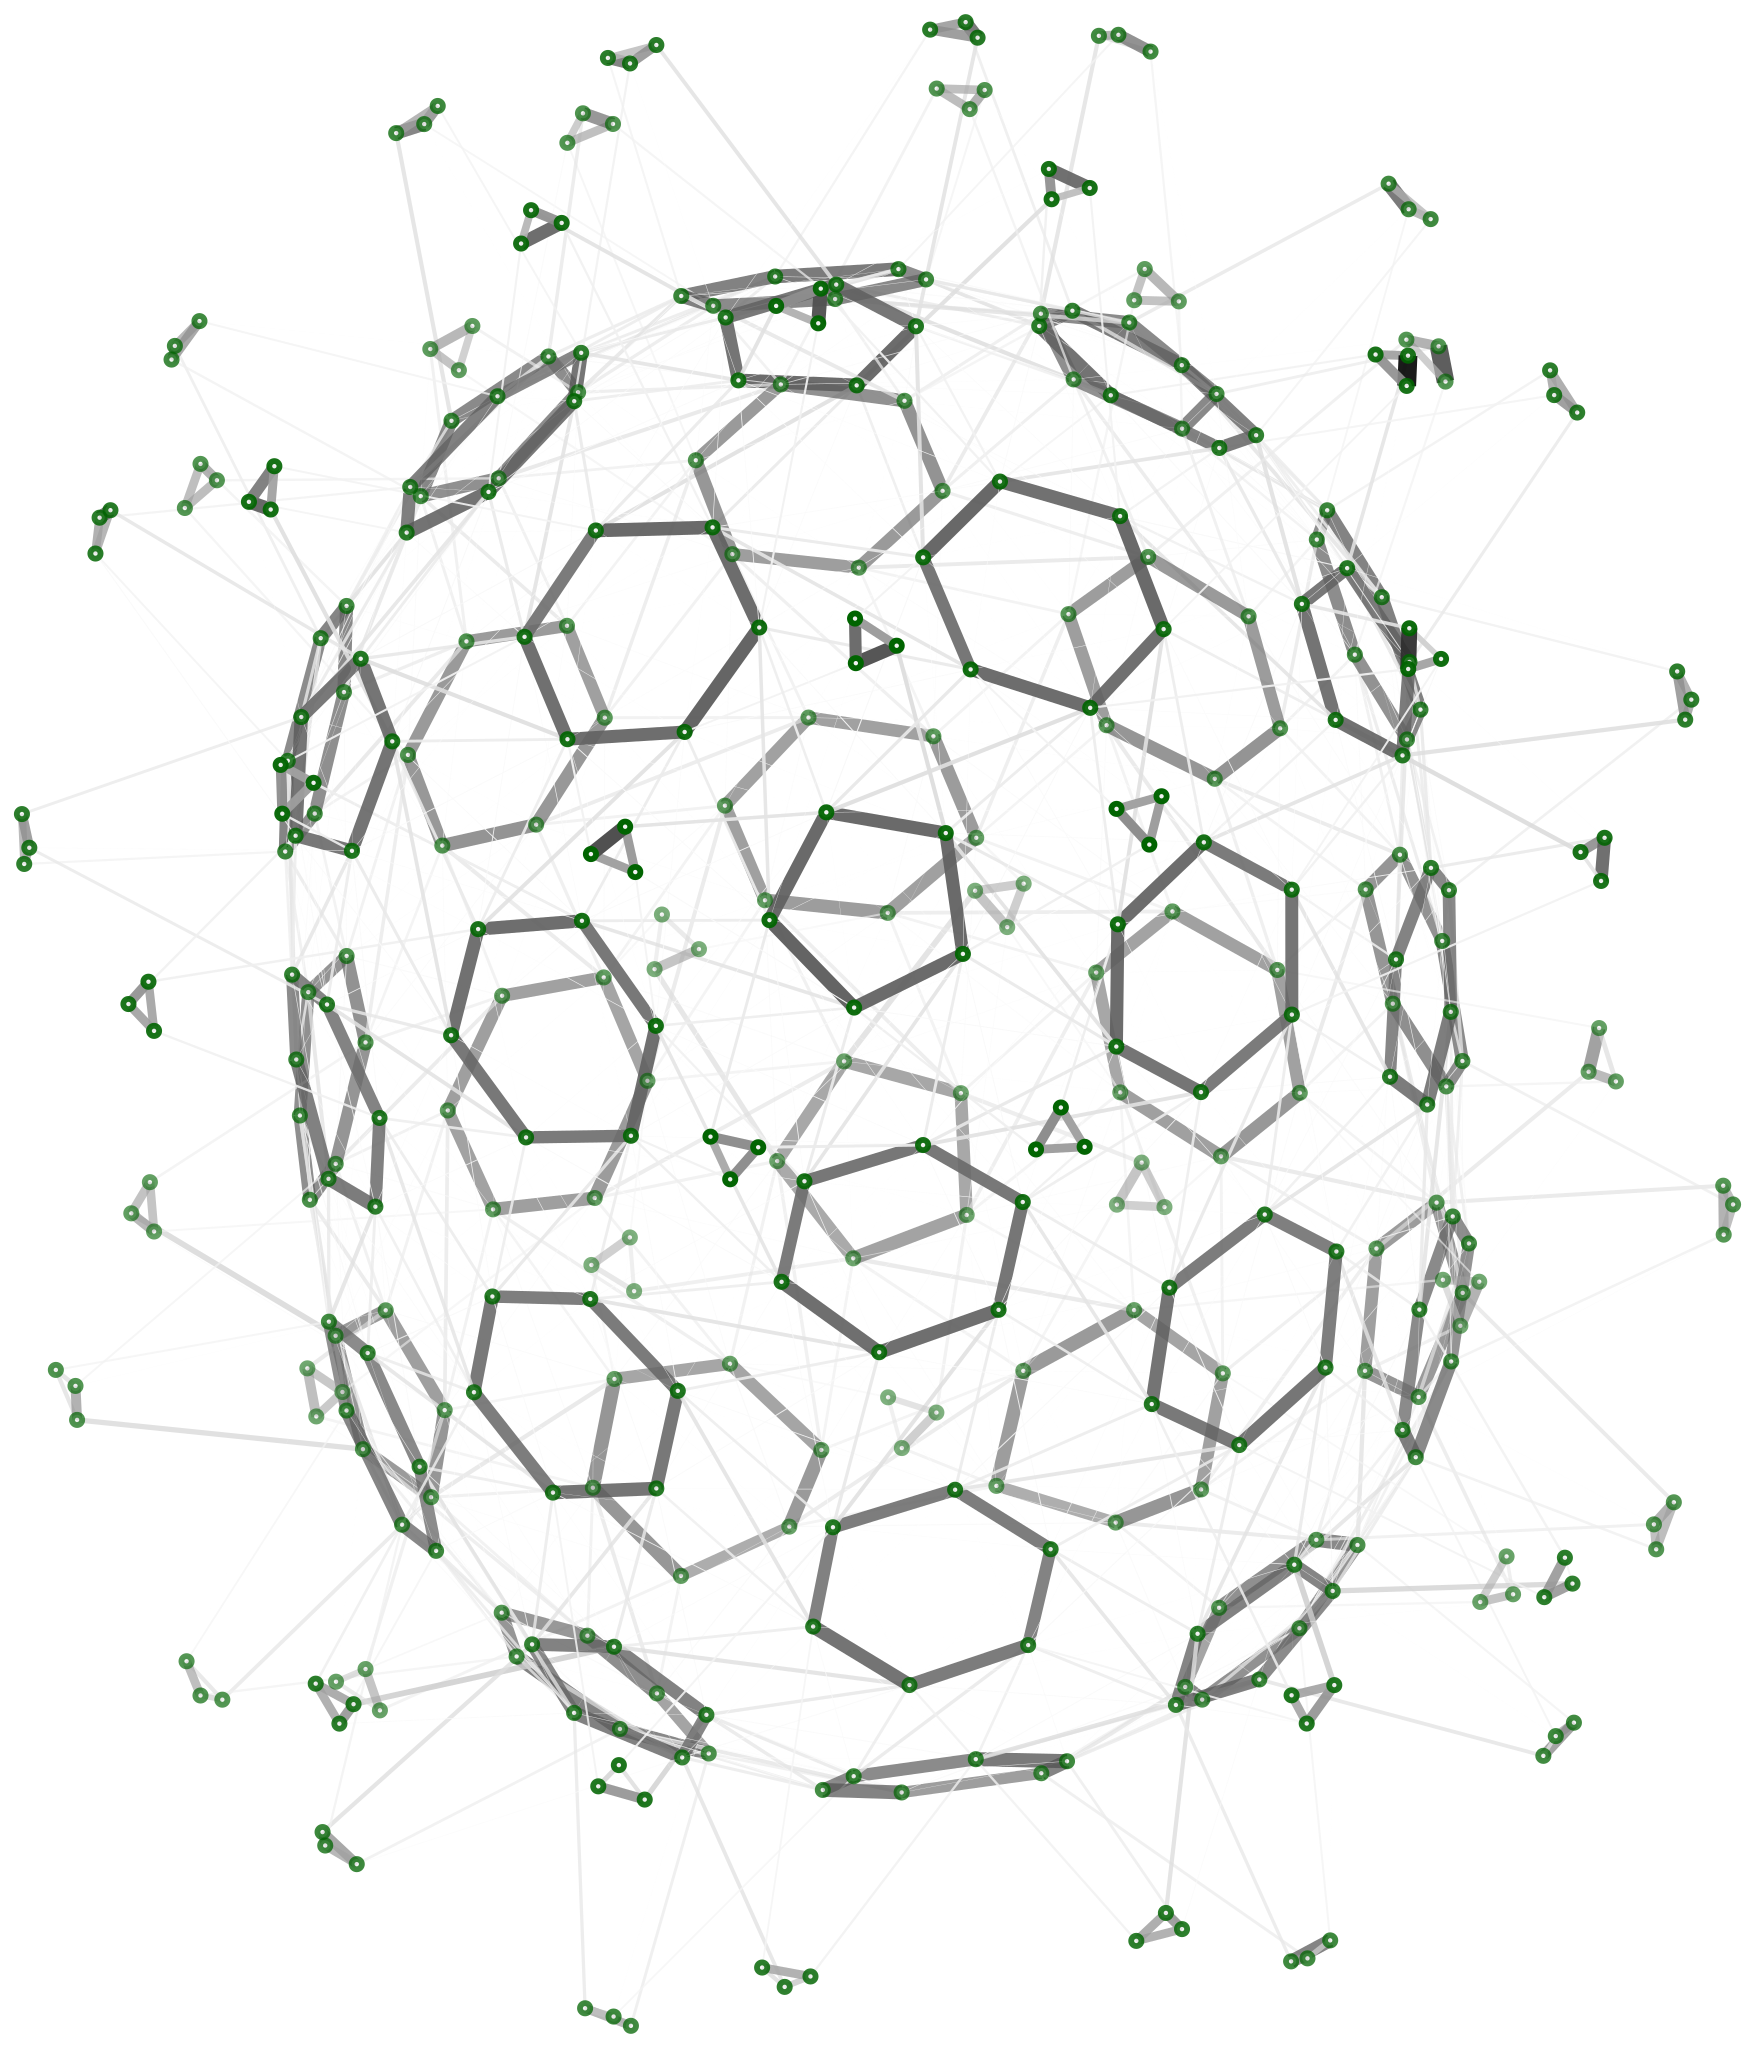

In [17]:
# This plot also gets saved as a file to the current working directory.
file_name_netrep: str = f'networkRepresentation_{weight_type}.svg'
ig.plot(G, file_name_netrep, **visual_style_network)


# DSSP, PTGL, PyMOL = False: Cell took 0.1407258511s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.1064929962s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0476276875s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0423605442s to execute with the pc specs.

<a id="section_ID_5.6"></a>
### 5.6 Graph Visualization with Focus on the Computed Partitions

<a id="section_ID_5.6.1"></a>
#### 5.6.1 Layout Style with Labels and Partitions

In the cell below the visual style for the graph is created with focus on the computed partitions, meaning it shows labels of the vertices and the partitioning.

The alpha value can be set to true for depth perception.

In [18]:
alpha = True

# General Cluster Layout:
visual_style_cluster: dict = visual_style.copy()
visual_style_cluster["vertex_size"]: int = 38
visual_style_cluster["vertex_color"]: list = [ig.color_name_to_rgba('white')
                                              for vertex in G.vs()]
visual_style_cluster["vertex_frame_width"]: int = 8
# First create the list and if required apply the modification for the alpha values.
visual_style_cluster["vertex_frame_color"]: list = \
                    ig.drawing.colors.ClusterColoringPalette(len(partitions[weight_type]))\
                    .get_many(partitions[weight_type].membership)

# With alpha value.
if alpha:
    visual_style_cluster["edge_color"]: list = \
                            [cmap(edge[weight_type]/maximum_weight)[:-1]
                             + ((alpha_values[edge.source] + alpha_values[edge.target])/2,)
                             for edge in G.es()]
    visual_style_cluster["vertex_frame_color"]: list = \
                            [visual_style_cluster["vertex_frame_color"][number][:-1]
                             + (alpha_values[int(vertex['id'])],)
                             for number, vertex in enumerate(G.vs())]
    visual_style_cluster["vertex_color"]: list = \
                            [visual_style_cluster["vertex_color"][number][:-1]
                             + (alpha_values[int(vertex['id'])],)
                             for number, vertex in enumerate(G.vs())]
# Without alpha value.
else:
    visual_style_cluster["edge_color"]: list = \
                            [cmap(weight/maximum_weight)
                             for weight in G.es[weight_type]]


# DSSP, PTGL, PyMOL = False: Cell took 0.3616204262s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.2554953098s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.1030654907s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0927824974s to execute with the pc specs.

<a id="section_ID_5.6.2"></a>
#### 5.6.2 Plotting the Graph

The below graph is shown in this size for better visibility. To have a look use the scrollbar at the bottom of the cell, or alternatively, go directly to the automatically saved .svg graph file (the name equals the 'file_name_clrep' below) in your jupyter notebook directory.

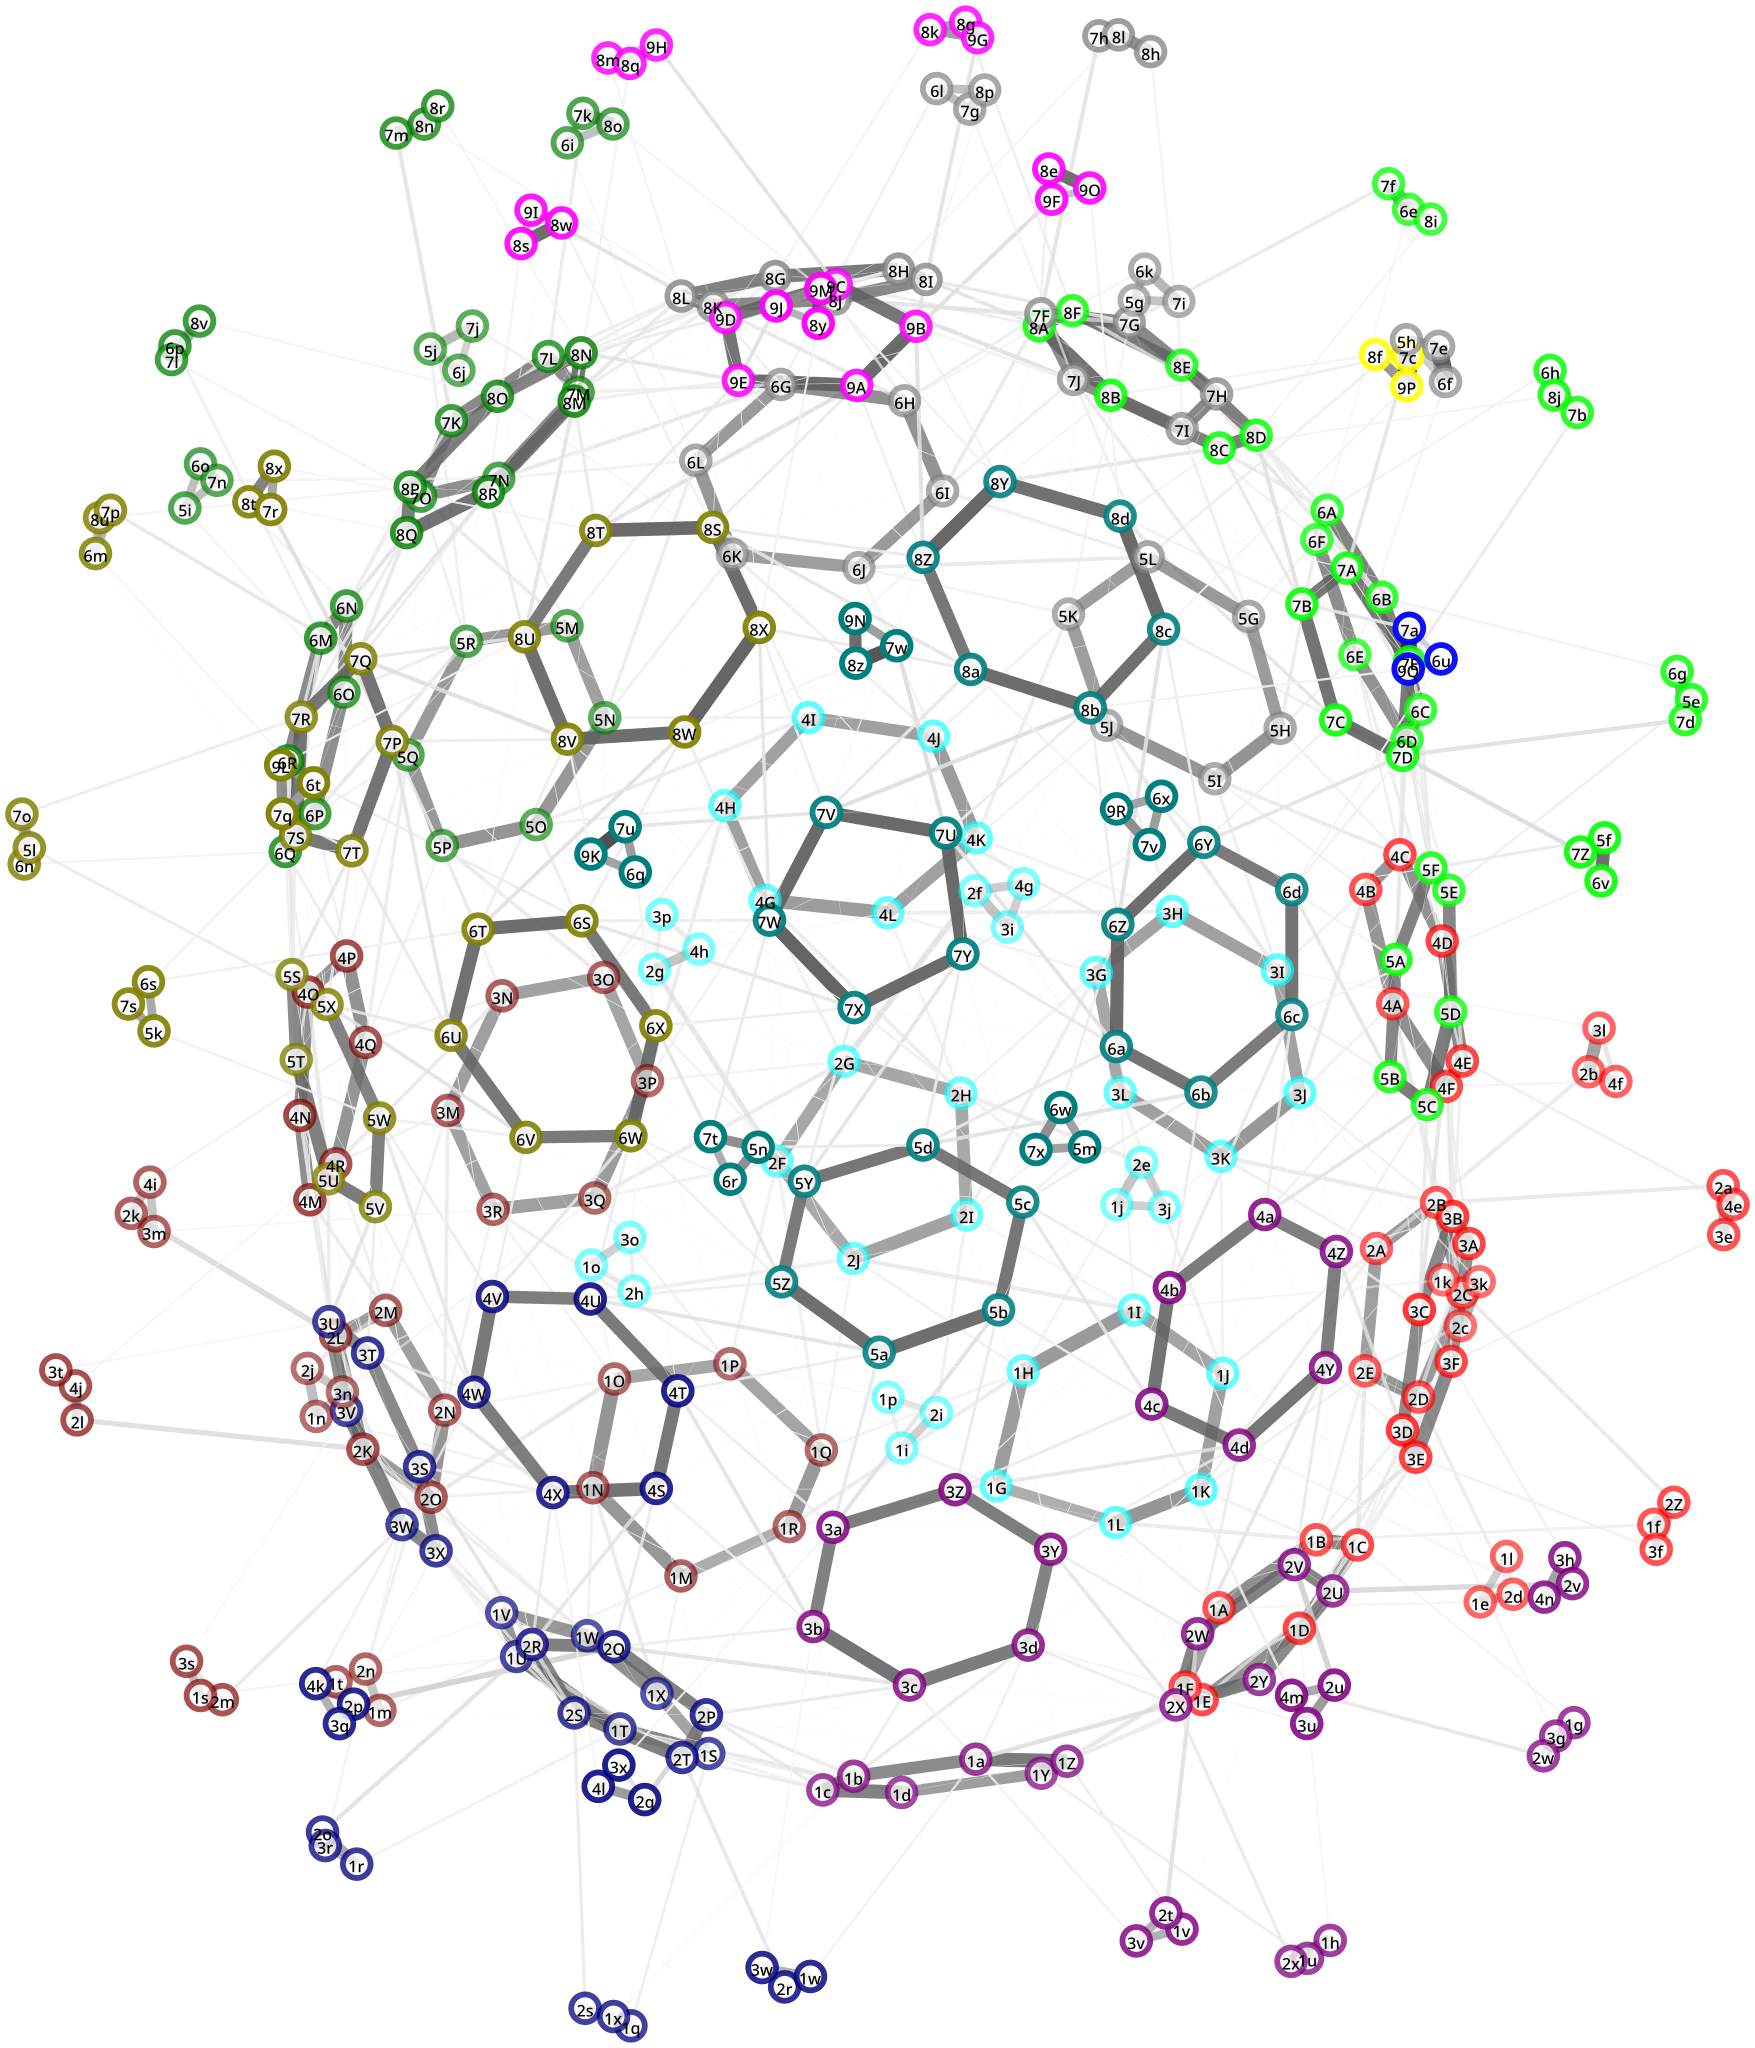

In [19]:
# This plot gets saved as a file to the current working directory.
file_name_clrep: str = f'clusterRepresentation_{weight_type}.svg'
ig.plot(partitions[weight_type], file_name_clrep, **visual_style_cluster)


# DSSP, PTGL, PyMOL = False: Cell took 0.3561341763s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.3434402943s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: Cell took 0.0511817932s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  Cell took 0.0587036610s to execute with the pc specs.

# The run time of the whole Jupyter Notebook has taken:
# DSSP, PTGL, PyMOL = False: 28.4766681194s to execute with the laptop specs.
# DSSP, PTGL, PyMOL = True:  02:12:33.51 h:m:s.ms to execute with the laptop specs.
# DSSP, PTGL, PyMOL = False: 15.2625920773s to execute with the pc specs.
# DSSP, PTGL, PyMOL = True:  02:05:36.71 h:m:s.ms to execute with the pc specs.